# METADATA
- fixation time graph
- task completion time
- subject variation in fixation

In [1]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.transform import Rotation as R

from tqdm import tqdm
from matplotlib import rc #change xtick & ytick size
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['font.family'] = "Arial"
from scipy.signal import butter, lfilter, freqz


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#========= read =========================================================================
"""
sfile: sorted params for each subject
ffile: trimmed feature files for all subs
dffile: time metadatafile for all subs
PARAMS: pamareter file for all subs


"""
spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
# file_name = "0919-f18r16ver2"
# fpath = "data/data_feature/" + file_name + ".gz"
# ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','target_idx','length', 'orig_length','h','v','d']]
print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

<bound method NDFrame.head of       sub_idx  file_idx  target_idx  length  orig_length          h  \
0           0         9           0     233          408 -30.000000   
1           0        42           0     168          440 -30.000000   
2           0       118           0     196          377 -30.000000   
3           0       141           0     175          369 -30.000000   
4           0        35           1     229          408 -30.000000   
...       ...       ...         ...     ...          ...        ...   
3451       23        29          34     245          442 -16.339005   
3452       23        91          35     171          373  -3.540169   
3453       23        66          35     191          390  -3.483050   
3454       23        31          35     197          397  18.433158   
3455       23        32          35     185          401  20.653209   

              v         d  
0    -20.000000  0.900000  
1    -20.000000  0.900000  
2    -20.000000  0.900000  
3    

## 1. Visualize Completion Time with (bar chart & distribution graph)
- bar chart is more intuitive
- KD graph can lead to misleading comprehension of data due to density values

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\2501826173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\2501826173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120


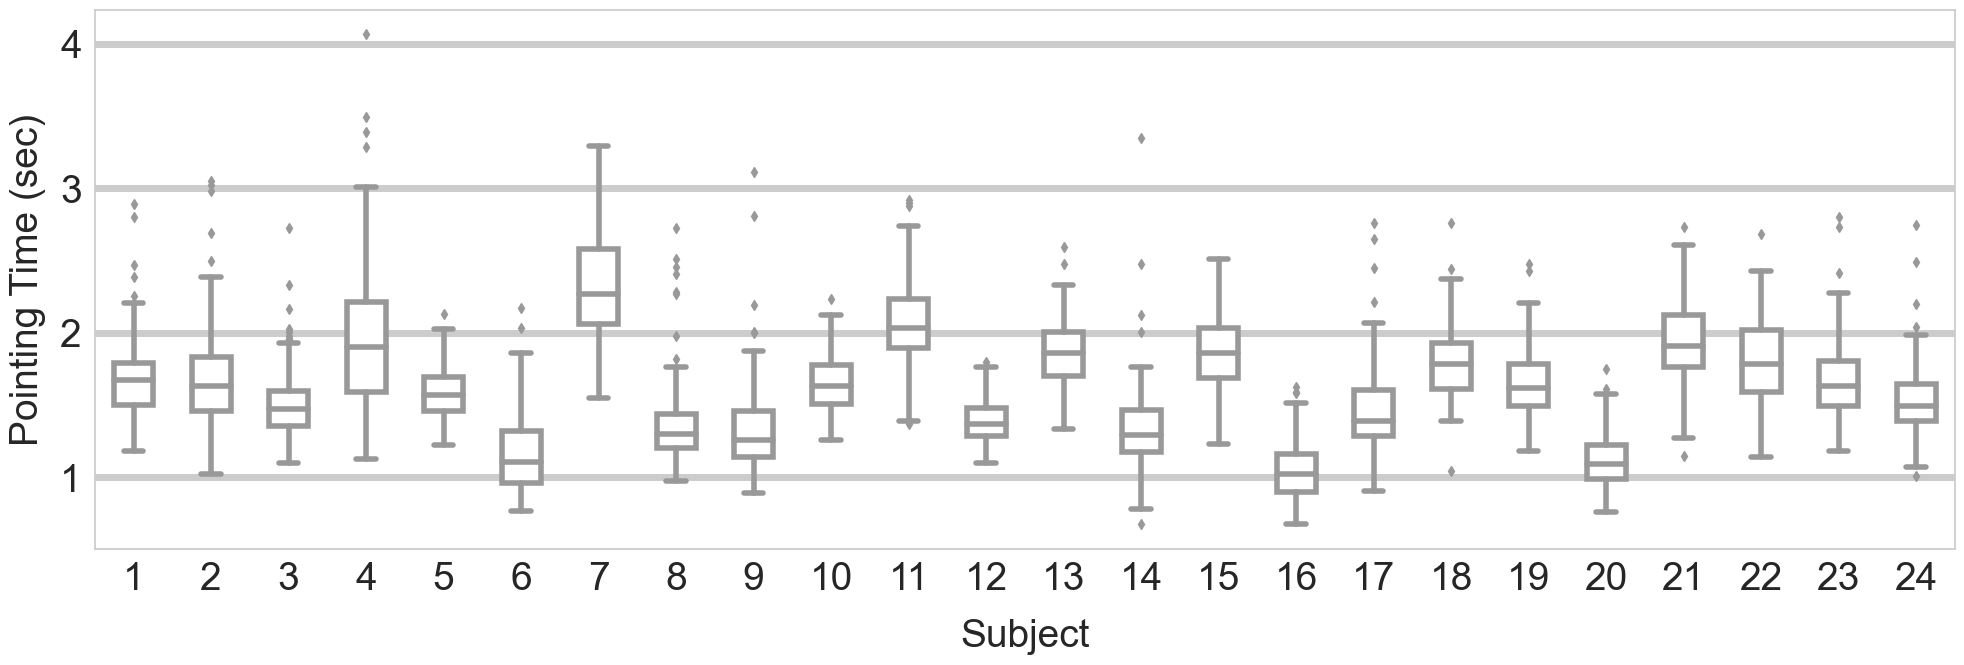

In [202]:
# data1 = file_method_grouping.loc[file_method_grouping['plot'] == 'gesture_distinction']

data = dffile[dffile.length != -1]
data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
fig1 = plt.figure(figsize = (24,7))
sns.set(style="ticks", palette='Set3')
sns.set_style("whitegrid")
sns.set_context("notebook", rc={"grid.linewidth": 5})


plot = sns.boxplot(x='sub_idx', y='length', data=data, color='white', width=0.5, linewidth=4)
plot.set_xlabel("Subject",fontsize=28, labelpad=15)
plot.set_ylabel("Pointing Time (sec)",fontsize=28, labelpad=10)
plot.tick_params(labelsize=28)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
# plt.title('completion_time', fontdict = {'fontsize' : 20})

# 2. Visualize Completion Time by target name

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3661065386.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'target_idx'] = data.loc[:,'target_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3661065386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120


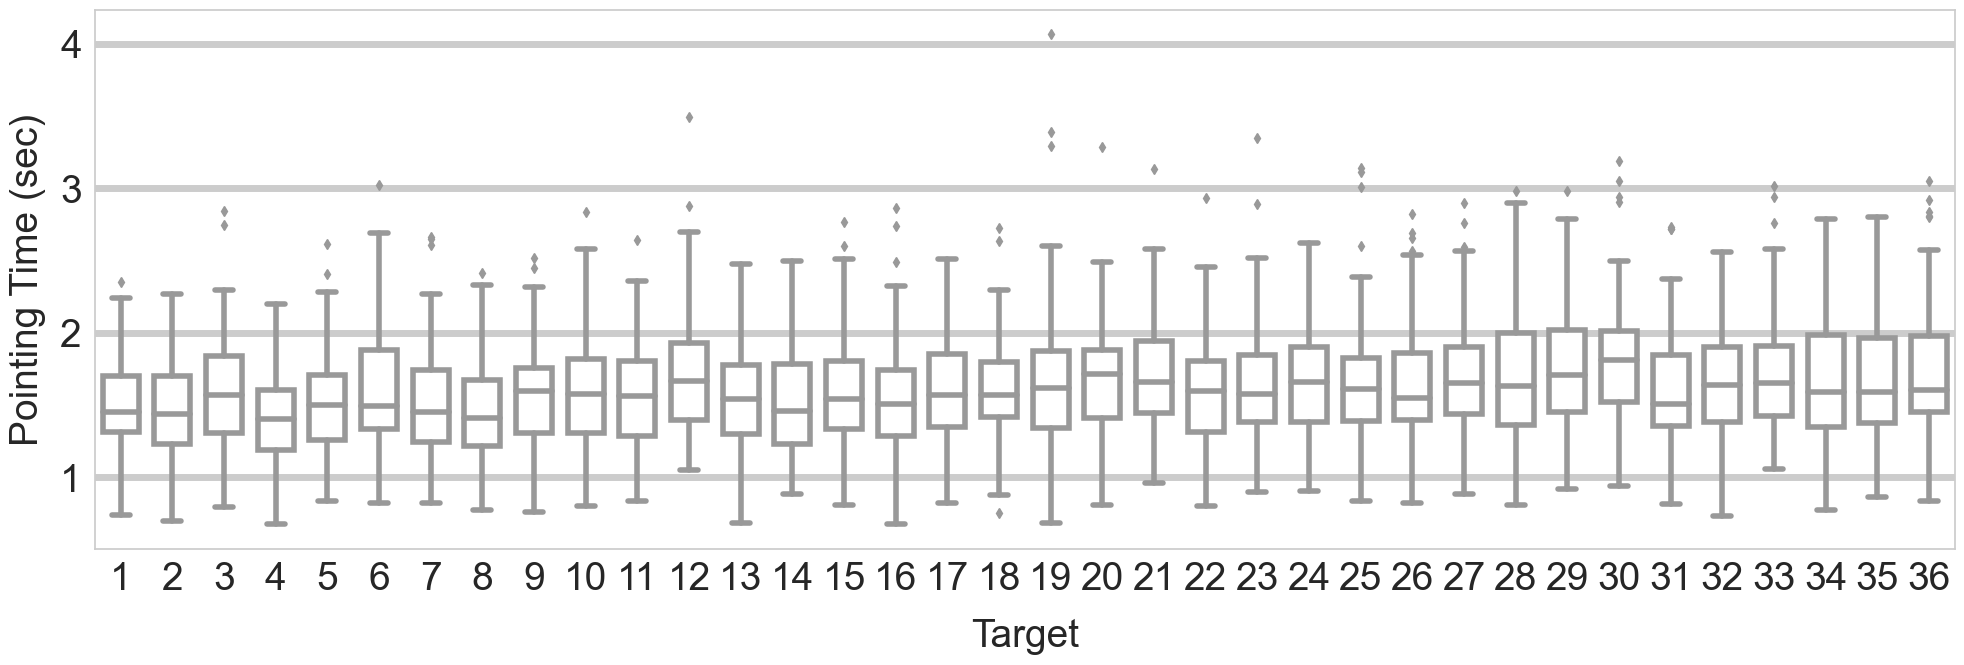

In [201]:
# data1 = file_method_grouping.loc[file_method_grouping['plot'] == 'gesture_distinction']

data = dffile[dffile.length != -1]
data.loc[:,'target_idx'] = data.loc[:,'target_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
fig1 = plt.figure(figsize = (24,7))
sns.set(style="ticks", palette='Set3')
sns.set_style("whitegrid")
sns.set_context("notebook", rc={"grid.linewidth": 5})


plot = sns.boxplot(x='target_idx', y='length', data=data, color='white', width=0.7, linewidth=4)
plot.set_xlabel("Target",fontsize=28, labelpad=15)
plot.set_ylabel("Pointing Time (sec)",fontsize=28, labelpad=10)
plot.tick_params(labelsize=28)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
# plt.title('completion_time', fontdict = {'fontsize' : 20})

# 3. tag with target number too
1. data_sub : for sub idx 2-16 (exclude subject \#1)
2. data_target: for all target_idx (where there are like 968 targets...)

In [163]:
data = dffile[dffile.length != -1]
data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
data.loc[:,'length'] = data.loc[:,'length'] / 120
data.loc[:,'orig_length'] = data.loc[:,'orig_length'] / 120

data_target = data.loc[(data["sub_idx"] >= 2) & (data["sub_idx"] <= 16)]
data_sub = data.loc[(data["sub_idx"] >= 2) & (data["sub_idx"] <= 16)]

# print(data_sub.head())
# print(data['target_idx'])
                                                      
#==============data_sub: 0-35 target=================
data_sub['target_idx'] = data_sub.groupby(['h', 'd', 'v']).ngroup()
#==============data_target: 0-1157 target===============
data_target['target_idx'] = data_target.groupby(['h', 'd', 'v']).ngroup()

print(data_sub.head())
print(data_target.head())

     sub_idx  file_idx  target_idx    length  orig_length     h     v    d
144        2        15           0  2.050000     3.866667 -30.0 -20.0  0.9
145        2        42           0  1.241667     3.400000 -30.0 -20.0  0.9
146        2        44           0  1.458333     3.591667 -30.0 -20.0  0.9
147        2       142           0  1.483333     3.575000 -30.0 -20.0  0.9
148        2        20           1  1.766667     3.491667 -30.0   0.0  0.9
     sub_idx  file_idx  target_idx    length  orig_length     h     v    d
144        2        15           0  2.050000     3.866667 -30.0 -20.0  0.9
145        2        42           0  1.241667     3.400000 -30.0 -20.0  0.9
146        2        44           0  1.458333     3.591667 -30.0 -20.0  0.9
147        2       142           0  1.483333     3.575000 -30.0 -20.0  0.9
148        2        20           1  1.766667     3.491667 -30.0   0.0  0.9


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3480884355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'sub_idx'] = data.loc[:,'sub_idx']  +1
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3480884355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'length'] = data.loc[:,'length'] / 120
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3480884355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


# 4. Normality Check
- Shapiro : N < 2000
- KS : N > 2000
- pass noramlity when p > 0.05

1. Null Hypothesis: your data = same as normal distribution (p > 0.05)
2. H1 Hypothesis: your data =/= not normal (p < 0.05)

## 4-1. Shapiro-Wilk Test (N < 2000)

ShapiroResult(statistic=0.9665243625640869, pvalue=1.2515321427800086e-21)
ShapiroResult(statistic=0.9665243625640869, pvalue=1.2515321427800086e-21)
0.8005511691291413
0.8005511691291413
ShapiroResult(statistic=0.994982123374939, pvalue=1.6897671457627439e-06)
ShapiroResult(statistic=0.994982123374939, pvalue=1.6897671457627439e-06)
ShapiroResult(statistic=0.887168288230896, pvalue=0.34574871616946135)
ShapiroResult(statistic=0.887168288230896, pvalue=0.34574871616946135)


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\735359605.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub["Log_col"] = np.log1p(data_sub["length"])
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\735359605.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target["Log_col"] = np.log1p(data_target["length"])


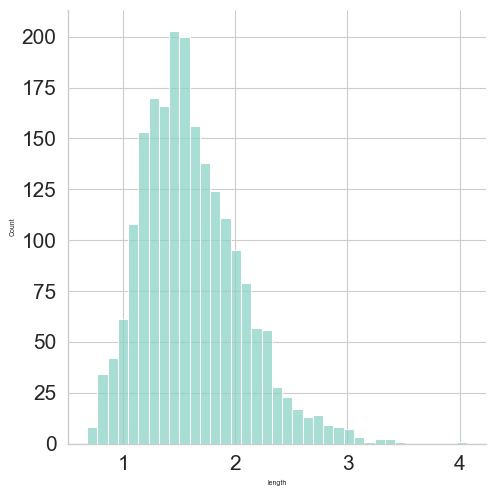

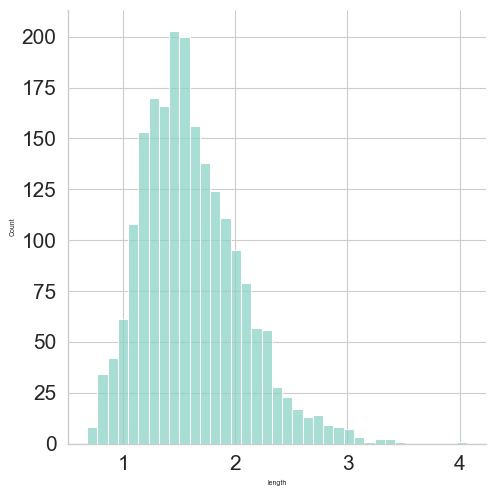

In [168]:
import math
import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm
import scipy.stats as stats

# #make this example reproducible
# np.random.seed(1)

# #generate dataset that contains 1000 log-normal distributed values
# lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

# #perform Shapiro-Wilk test for normality
# print(shapiro(lognorm_dataset))


#===Normality test not passed due to P value under 0.05. Need skewness test======
sns.displot(data_sub.length)
sns.displot(data_target.length)
print(shapiro(data_sub['length']))
print(shapiro(data_target['length']))

#====Skewness under 2 can conform to a test===============
print(abs(stats.skew( data_sub['length'] , bias = False)))
print(abs(stats.skew( data_target['length'] , bias = False)))


# If skewness is less than -1 or greater than 1, the distribution is highly skewed.
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
# both data are positively skewed to around 0.8



#====Do Lognormal========================================
# shape, location, scale = scipy.stats.lognorm.fit(listofdata)
# mu, sigma = np.log(scale), shape

# scipy.stats.kstest(listofdata, "lognorm", scipy.stats.lognorm.fit(listofdata))
# data_sub["Log_col"] = np.log1p(data_sub["length"])
# data_target["Log_col"] = np.log1p(data_target["length"])
# print(shapiro(data_sub['Log_col']))
# print(shapiro(data_target['Log_col']))

print( shapiro(  scipy.stats.lognorm.fit(data_sub['length'])) )
print( shapiro(  scipy.stats.lognorm.fit(data_target['length'])) )

### 4-2. KS normality check (N > 2000)

NormaltestResult(statistic=223.07622611067768, pvalue=3.6275464163112525e-49)
NormaltestResult(statistic=223.07622611067768, pvalue=3.6275464163112525e-49)
KstestResult(statistic=0.7904596300088251, pvalue=0.0, statistic_location=0.925, statistic_sign=-1)
KstestResult(statistic=0.7904596300088251, pvalue=0.0, statistic_location=0.925, statistic_sign=-1)
KstestResult(statistic=0.012885927415909992, pvalue=0.8738060594359212, statistic_location=1.9, statistic_sign=-1)
KstestResult(statistic=0.012885927415909992, pvalue=0.8738060594359212, statistic_location=1.9, statistic_sign=-1)
0.8005511691291413
0.8005511691291413


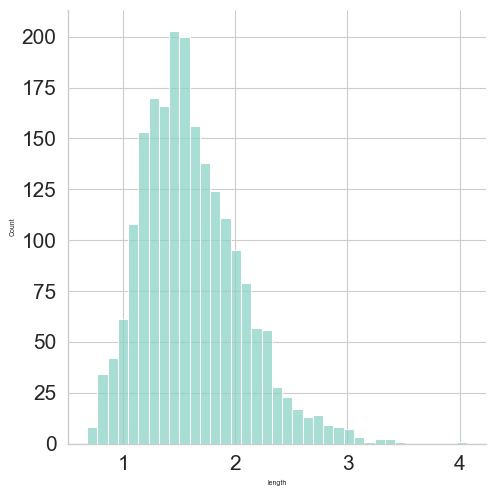

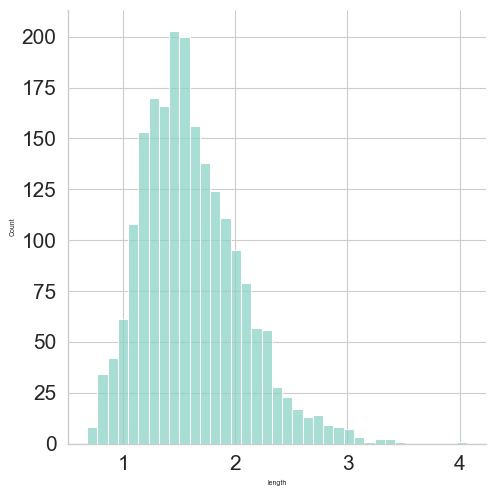

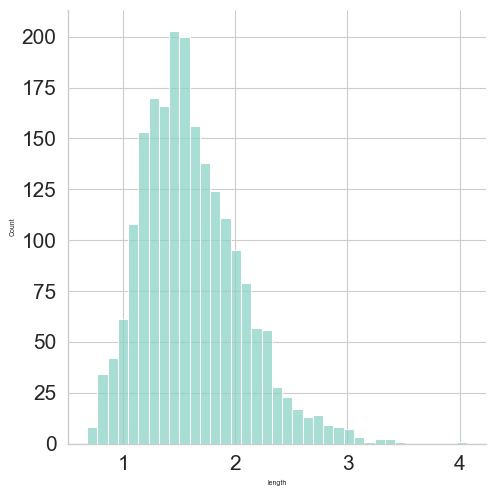

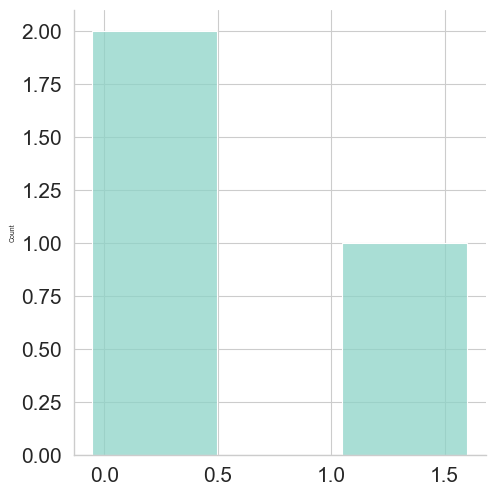

In [174]:
import seaborn as sns
import math
import numpy as np
from scipy.stats import kstest
from scipy.stats import lognorm

# #make this example reproducible
# np.random.seed(1)
# #generate dataset that contains 1000 log-normal distributed values
# lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)
# #perform Kolmogorov-Smirnov test for normality
# kstest(lognorm_dataset, 'norm')

#===Normality test not passed due to P value under 0.05. Need skewness test======
sns.displot(data_sub.length)
sns.displot(data_target.length)
print(scipy.stats.mstats.normaltest(data_sub.length))
print(scipy.stats.mstats.normaltest(data_target.length))
print(kstest(data_sub['length'], 'norm'))
print(kstest(data_target['length'], 'norm'))

print(scipy.stats.kstest(data_sub['length'], "lognorm", scipy.stats.lognorm.fit(data_sub['length'])))
print(scipy.stats.kstest(data_target['length'], "lognorm", scipy.stats.lognorm.fit(data_target['length'])))

sns.displot(data_sub.length)
sns.displot(data_target.length)


#====Skewness under 2 can conform to a test===============
print(abs(stats.skew( data_sub['length'] , bias = False))) #0.8: moderately skewed
print(abs(stats.skew( data_target['length'] , bias = False))) #0.8: moderately skewed

# If skewness is less than -1 or greater than 1, the distribution is highly skewed.
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
# both data are positively skewed to around 0.8

## 4-2. Distribution Test


- difference between distributions of different independent group

- Null(Should be followed): No changes in distribution (P>0.05)
- H1 : reject null hypothesis

In [204]:
from scipy.stats import bartlett
from scipy.stats import levene

#https://stackoverflow.com/questions/26202930/pandas-how-to-apply-scipy-stats-test-on-a-groupby-object
#---------------------------------------------------------------------------------------
# scipy.stats tests expects only values columns
# and groupby splits a DataFrame into (group_name, DataFrame) tuples. 

# Given a group column 1 and a value column 2, 
# you can use list comprehension with a groupby object df.groupby(1), 

# extract only the value column df.groupby(1)[2] 
# and then iterate through the groupby tuples keeping the values (col) and discarding the names(col_names).
#---------------------------------------------------------------------------------------



#1. drop everything except group num & values
data_sub2=data_sub.drop(['file_idx', 'target_idx', 'orig_length', 'h','v','d'],axis=1)
data_target2=data_target.drop(['sub_idx', 'file_idx', 'orig_length', 'h','v','d'],axis=1)
# print(data_sub2.head())
# print(data_target2.head())
# print(data_target['length'], 'norm'))

#2. grouby 1st columm for value column 2 


 # data_sub.groupby(['h', 'd', 'v']).ngroup()
sub_groups = data_sub2.groupby(['sub_idx'])
target_groups = data_target2.groupby(['target_idx'])
# print(sub_groups.groups)
# print(target_groups.groups)

sub_group_values = []
for gname,g in sub_groups:
    # print(gname)
    sub_group_values.append(g.length)

target_group_values = [] 
for gname,g in target_groups:
    # print(gname)
    # print(g.length)
    target_group_values.append(g.length)


# Levene 검정은 표본이 정규성을 만족하든 만족하지 않든 상관없이 사용할 수 있다.
print(stats.levene( *sub_group_values ))  # very small--(x)
print(stats.levene( *target_group_values))# 0.16 ----------> 통과

# bartlett은 정규성 검정을 꼭 통과해야 한다
print(stats.bartlett( *sub_group_values )) # veryvery small (x)
print(stats.bartlett( *target_group_values))# too small (x)


# Per subject는 분산도 다르기 때문에 도저히 ANOVA를 돌릴 수도 없다. 애초에 그냥 분산이 다르다. 뭔가 subject내의 variance가 크기 때문에 그런거 같다.
# Per target은 아슬아슬하게 정규성과 분산은 통과해서 ANOVA를 돌릴 수 있다. (등분산 가정은 levene만 통과했다.)




144    2.050000
145    1.241667
146    1.458333
147    1.483333
148    1.766667
         ...   
283    1.491667
284    2.383333
285    1.583333
286    1.475000
287    1.516667
Name: length, Length: 138, dtype: float64 288    1.416667
289    1.666667
290    1.391667
291    1.316667
292    1.308333
         ...   
426    1.308333
427    1.958333
429    1.533333
430    1.275000
431    1.591667
Name: length, Length: 143, dtype: float64 432    2.216667
433    1.766667
434    1.858333
435    1.491667
436    2.091667
         ...   
571    1.500000
572    2.383333
573    1.933333
574    1.758333
575    1.358333
Name: length, Length: 135, dtype: float64 576    1.841667
577    1.675000
578    1.450000
579    1.400000
580    1.758333
         ...   
715    1.383333
716    1.575000
717    1.716667
718    1.716667
719    1.650000
Name: length, Length: 139, dtype: float64 720    1.333333
721    1.383333
722    1.383333
723    1.083333
724    1.233333
         ...   
859    1.016667
860    1.258333


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\103067111.py:35: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for gname,g in sub_groups:
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\103067111.py:40: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for gname,g in target_groups:


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_24520\3520315866.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(sampled, kde_kws={'label': 'kde'}, label='histogram')


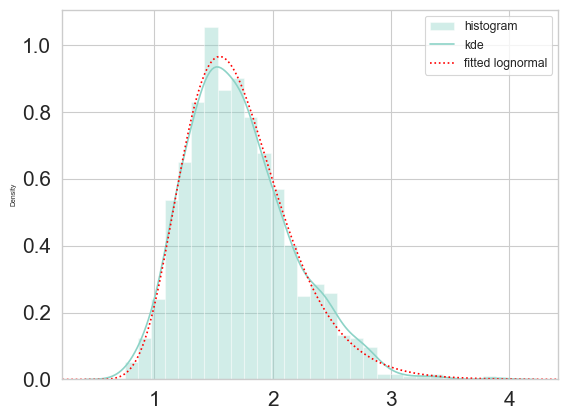

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

sampled = np.random.lognormal(0.5, 0.25, 1000)
ax = sns.distplot(sampled, kde_kws={'label': 'kde'}, label='histogram')

shape, location, scale = stats.lognorm.fit(sampled)
x_min, x_max = ax.get_xlim()
xs = np.linspace(x_min, x_max, 200)
ax.plot(xs, stats.lognorm.pdf(xs, s=shape, loc=location, scale=scale), color='r', ls=':', label='fitted lognormal')
ax.set_xlim(x_min, x_max) # set the limits back to the ones of the distplot
plt.legend()

# 5. one-way ANOVA test

In [179]:
from scipy.stats import f_oneway
# https://www.statology.org/one-way-anova-python/
# https://www.statology.org/repeated-measures-anova-python/



# #enter exam scores for each group
# group1 = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
# group2 = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
# group3 = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]
# f_oneway(group1, group2, group3)

#example: Fcritical value (2, 12, p < 0.05) = 3.89
f_oneway(*target_group_values)
# (F(35, 505) = 3.09, p*** < 0.05)

F_onewayResult(statistic=3.0948084926329114, pvalue=3.948792841570625e-09)

# ETC. Completion Time with Distribition - Nor recommended - hard to mistake meaning

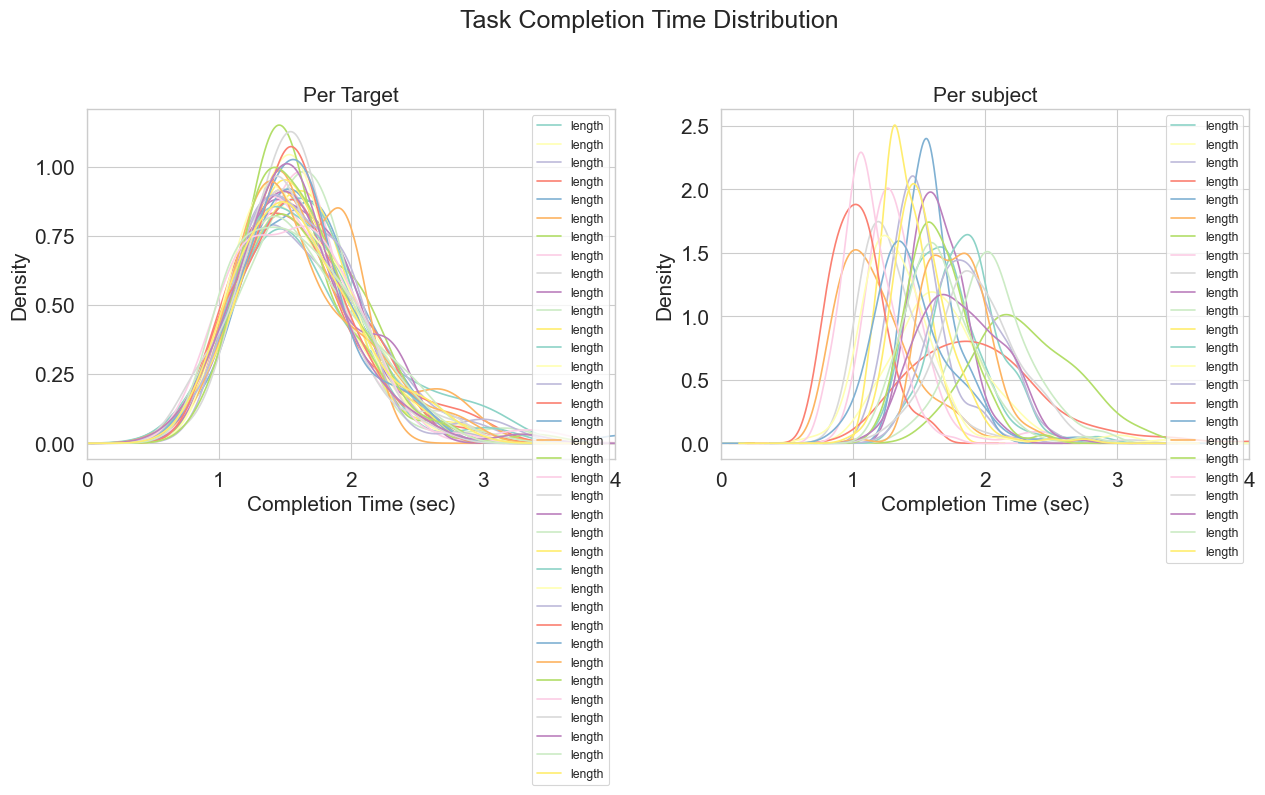

In [52]:

# need ticks to act as grid : https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

def plot_tasktime_distribution(dffile):
    # https://note.nkmk.me/en/python-pandas-multiple-conditions/#select-rows-by-multiple-conditions
    """
    dffile = pd of ['sub_idx','file_idx','length', 'h','v','d']
    
    1. use sub(0-15)
    2. isolate by 36 combinations
    3. find mean avg / std for length
    """
    
    
    # ==== common plot ==============================
    plt.figure(figsize=(15,10))
    plt.suptitle("Task Completion Time Distribution", fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    
    # ==== grid ticks ==============================
    major_ticks = np.arange(0, 5, 20)
    minor_ticks = np.arange(0, 5, 5)
    
    
    # ===== plot by combination =====================
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Per Target", fontsize=15)
    ax1.set_xlabel('Completion Time (sec)', fontsize=15)
    ax1.set_ylabel('density', fontsize=15)
    ax1.locator_params(nbins=5, axis='x') #xtick density
    ax1.locator_params(nbins=6, axis='y') #xtick density
    ax1.set_xlim(0, 4)
    df = dffile.loc[ dffile['sub_idx']<16]
    df_combination = pd.DataFrame()
    for cIdx in range(36):
        v1, v2, v3, v4 = cIdx, 36+cIdx, 72+cIdx, 108+cIdx
        df_comb = df.loc[ (df['file_idx'] == v1) | (df['file_idx'] ==v2) | (df['file_idx'] == v3) | (df['file_idx'] == v4)]
        df_comb = df_comb.loc[df_comb['length'] > -1].reset_index(drop=True)
        col_name = 'c' + str(cIdx)
        df_comb_length = df_comb['length']/120
        # print(df_comb_length.shape[0], "//", round(df_comb_length.mean(),2), "/", round(df_comb_length.min(),2), "/", round(df_comb_length.max(),2), "/", round(df_comb_length.std(),2))
        ax = df_comb_length.plot.kde()

    
    
    # ===== plot by subject =========================
    ax2 = plt.subplot(2, 2, 2)    
    ax2.set_title("Per subject", fontsize=15)
    ax2.set_xlabel('Completion Time (sec)', fontsize=15)
    ax2.set_ylabel('density', fontsize=15)
    ax2.locator_params(nbins=5, axis='x') #xtick density    
    ax2.locator_params(nbins=6, axis='y') #xtick density
    ax2.set_xlim(0, 4)
    
    df = dffile       
    for sIdx in range(24):
        df_sub = df.loc[ (df['sub_idx'] == sIdx) ]
        df_sub = df_sub.loc[df_sub['length'] > -1].reset_index(drop=True)
        df_sub_length = df_sub['length']/120
        # print(sIdx, "//", round(df_sub_length.mean(),2), "/", round(df_sub_length.min(),2), "/", round(df_sub_length.max(),2), "/", round(df_sub_length.std(),2))            
        ax = df_sub_length.plot.kde()
        
    ax1.legend()
    ax2.legend()
    
matplotlib.rcParams['font.family'] = "Arial"    
plot_tasktime_distribution(dffile)        

In [115]:
rand = np.random.RandomState(1)
df = pd.DataFrame({'A': ['foo', 'bar'] * 3,
                   'B': rand.randn(6),
                   'C': rand.randint(0, 20, 6)})

In [116]:
print(df)

     A         B   C
0  foo  1.624345   5
1  bar -0.611756  18
2  foo -0.528172  11
3  bar -1.072969  10
4  foo  0.865408  14
5  bar -2.301539  18


In [130]:

df = pd.DataFrame({'1': ['P','P','P','P','C','C','C'],
                   '2': [21,13,25,75,10,105,101]})

grouper= df.groupby('1')
variables = df.columns[0]
for _, g in grouper:
    print(g['2'])

    
# grouper = df.groupby('FinancialDistress')
# variables = df.columns[1:]    
# res = pd.concat([pd.DataFrame(describe(g[x]) for _, g in grouper)\
#                    .reset_index().assign(cat=x).set_index(['cat', 'index']) \
#                  for x in variables], axis=0)


# values_per_group = [col for col_name, col in df.groupby(1)[2]]
# ss.ranksums(*values_per_group)

4     10
5    105
6    101
Name: 2, dtype: int64
<generator object <genexpr> at 0x000001A3C626C890>
0    21
1    13
2    25
3    75
Name: 2, dtype: int64
<generator object <genexpr> at 0x000001A3C626CB30>
